# Конструирование суррогатной модели

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Основная задача этой главы - изучить отображение $y = f(\mathbf{x})$ , производящееся в так называемом "чёрном ящике", который скрывает физику этого отображения, преобразующего вектор $\mathbf{x}$ в скалярную величину $y$ . Этот черный ящик может принимать форму физического или компьютерного эксперимента, например, кода, реализующего метод конечных элементов, который вычисляет максимальное напряжение $(f)$ для заданных размеров изделия $\mathbf{(x)}$. Общий метод решения данной проблемы состоит следующем: сначала собираются выходные значения $y^{(1)},y^{(2)},...,y^{(n)}$, каждое из которых является результатом действия отображения $f$ на входные данные $\mathbf{x}^{(1)},\mathbf{x}^{(2)},...,\mathbf{x}^{(n)}$, а затем (на основе наблюдений) ищется функция $\hat{f}(x)$, которая описывает отображение чёрного ящика $f$ наилучшим образом.  
В этой главе мы обсудим основы и некоторые технические детали ряда конкретных типов суррогатных моделей, способных решить поставленную задачу. Однако начнём мы с обсуждения ключевых этапов процесса построения суррогатной модели.

## Процесс Моделирования

### Первая стадия: Подготовка данных и выбор Подхода к моделированию

В разделе 1 рассматриваются два предварительных шага этого этапа. Первый - это идентификация: с помощью небольшого числа наблюдений определить те параметры входных данных, которые оказывают существенное влияние на $f$; то есть происходит определение кратчайшего вектора проектной переменной $\mathbf{x} = \{x_1, x_2,..., x_k\}^T$, который, в рассматриваемых диапозонах всех своих компонент может сильно влиять на поведение чёрного ящика. Если бы чёрный ящик был электронным устройством, оснащенным большим набором элементов управления, то этот шаг сводился бы к выявлению $k$ элементов управления, которые при изменении влияют на его поведение. Эта операция осложнена возможными взаимодействиями между элементами управления. На этом этапе также необходимо установить диапазоны различных проектных переменных.  

Второй шаг - сбор $n$ штук векторов длины $k$ в список $\mathbf{X} = \{ \mathbf{x}^{(1)}, \mathbf{x}^{(2)},...,\mathbf{x}^{(n)} \}^T$, таким образом, чтобы этот набор максимально полно представлял собой пространство проектирования. Основная проблема в том, что n часто невелико, т.к. оно ограничено вычислительной и временной стоимостью, приходящейся на каждое наблюдение $f(\mathbf{x}^{(i)})$.  
Возможно, здесь стоит повторить, что на этом шаге неплохо масштабировать \mathbf{x} в единичный куб $[0,1]^k$, что может упростить некоторые последующие математические вычисления и избавить нас от множества проблем многомерного масштабирования.  

Поскольку в главе 1 изложен ряд методов для выполнения вышеуказанного, здесь мы рассмотрим следующую фазу процесса - фактическую попытку изучения $f$ с помощью пар данных $\{(x^{(1)},y^{(1)}),(x^{(2)},y^{(2)}), ...(x^{(n)},y^{(n)})\}$. Этот так называемый _процесс обучения под наблюдением или на основе примеров_ (___обучениие с учителем___), по сути, представляет собой поиск в пространстве всех возможных функций $\hat{f}$, которые воспроизводили бы наблюдения $f$.  

Это пространство бесконечно. В конце концов, можно нарисовать любое количество (гипер)поверхностей, прохождящих в определенном диапазоне (с учетом экспериментальной ошибки) известных наблюдений. Однако подавляющее большинство из них будет очень плохо обобщаться; то есть они будут практически бесполезны для прогнозирования ответов на новых данных, в чем и заключается цель данной задачи.

Рассмотрим несколько экстремальный пример функции "иголка(иголки) в стоге сена":


$$ \hat{f} = \begin{cases}
   y^{(1)} &\text{if $x = x^{(1)}$}\\
   y^{(2)} &\text{if $x = x^{(2)}$}\\
   ...\\
   y^{(n)} &\text{if $x = x^{(n)}$}\\
   0 &\text{иначе}\\ 
 \end{cases} $$

Очевидно, что, хотя все обучающие данные могут быть воспроизведены с помощью этого предиктора, но есть, по крайней мере, в отношении большинства инженерных функций, что-то сильно противоречащее интуиции и тревожащее в том, что он предсказывает 0 везде, кроме обучающих точек. Конечно, есть небольшая вероятность того, что функция действительно выглядит как (1), и по какой-то необычайной случайности нам довелось исследовать её именно там, где находятся все иглы, но это маловероятно.

Можно было бы придумать множество других, возможно, менее надуманных примеров, которые также кажутся какими-то неестественными и, более того, плохо обобщаются. В конечном счете все это говорит о том, что нам нужны какие-то систематические инструменты фильтрации таких бессмысленных предсказателей. Некоторые ученые занимают здесь Байесовскую позицию, например, философия, отстаиваемая Расмуссеном и Уильямсом (2006), заключается в том, чтобы "заранее дать вероятность каждой возможной функции, причём более высокие вероятности дать функциям, которые мы считаем более вероятными, например, потому что они более гладкие, чем другие функции".  

Подход, который мы будем использовать в дальнейшем, заключается в том, чтобы заранее опредлить структуру $\hat{f}$ (например, полином третей степени), встроить её в алгоритм моделирования и выполнить поиск по пространству её параметров для настройки приближения к наблюдениям. Например, рассмотрим одну из простейших возможных моделей: $\hat{f}(\mathbf{x},\mathbf{w}) = \mathbf{w}^T \mathbf{x} + v$. Изучение f с помощью этой модели подразумевает, что мы определились с ее структурой – это будет гиперплоскость – и процесс подгонки модели состоит в нахождении $k + 1$ параметров (вектор наклона w и перехват v), для которых значение выражения $\mathbf{w}^T \mathbf{x} + v$ наилучшим образом соответствует данным (это будет выполнено на второй стадии).  

Все вышесказанное часто дополнительно осложняется наличием шума в наблюдаемых откликах (будем считать, что проектные вектора \textbf{x} никоим образом не повреждены). Мы обсуждали природу этого шума в начале главы 1. Здесь мы концентрируемся на изучении таких данных, для которых иногда присутсвует вероятность ___перенасыщения___.
Перенасыщение происходит, когда модель в некотором смысле слишком гибкая и слишком точно соответствует обучающим данным, то есть соответствует шуму, а также фактическому базовому поведению, которое мы пытаемся смоделировать. На второй стадии процесса суррогатного строительства эта проблема _управления сложностью_ решается с помощью процесса оценки параметров модели фиксированной конструкции, но здесь, на этапе выбора типа модели, также требуется некоторое предвидение в этом направлении.  

Обычно этот шаг связан с физическими соображениями; то есть выбор метода моделирования зависит от наших ожиданий того, как может выглядеть лежащий в основе ответ. Например, если у нас есть некоторые наблюдения за напряжением в упруго деформированном твердом теле в ответ на небольшие деформации, имеет смысл моделировать напряжение с помощью простого линейного приближения.  
Если такое понимание физики недоступно и мы не сможем учесть, скажем, линейность данных на данном этапе, мы в конечном итоге примем сложную, чрезмерно гибкую модель. Это не будет концом света (в конце концов, этап оценки параметров, как мы надеемся, "линеаризует" аппроксимацию путем соответствующего выбора параметров, управляющих ее формой), но мы упустим возможность получить алгебраически простую, надежную модель.  

И наоборот, если мы ошибочно предположим, что данные получены, скажем, из базового квадратичного процесса, а на самом деле истинная функция $f$ имеет множество пиков и впадин, на этапе оценки параметров мы не сможем компенсировать неудачно выбранную модель. Квадратичная просто будет слишком жесткой, чтобы соответствовать мультимодальной функции, каковы бы ни были ее параметры.

### Вторая стадия: Оценка параметров и обучение

Давайте предположим, что на первой стадии мы определили $k$ проектных переменных, получили набор обучающих данных и выбрали общую структуру модели $\hat{f}(\mathbf{x},\mathbf{w})$, где точная форма модели определяется набором параметров $\mathbf{w}$. Теперь мы сталкиваемся с проблемой оценки параметров: как нам выбрать такие $\mathbf{w}$, чтобы модель наилучшим образом соответствовала данным? Существует много критериев оценки, но здесь мы обсудим два.

#### Метод Максимального Правдоподобия

Если даны набор параметров $\mathbf{w}$ и сама модель $\hat{f} (\mathbf{x},\mathbf{w})$, то мы можем вычислить вероятность того, что набор данных $\{(\mathbf{x}^{(1)},y^{(1)} \pm \epsilon),(\mathbf{x}^{(2)},y^{(2)} \pm \epsilon),...,(\mathbf{x}^{(n)},y^{(n)} \pm \epsilon)\}$ будет получен из $\hat{f}$ (где $\epsilon$ - некоторая небольшая постоянная погрешность вокруг каждой точки). Мы можем предположить, что ошибки независимо случайным образом распределены в соответствии с нормальным распределением со стандартным отклонением $\sigma$, тогда вероятность получения данного набора данных равна  

$$P = \frac{1}{(2\pi \sigma^2)^{n/2}} \prod\limits_{i=1}^n \Bigr\{ exp \Bigr[ - \frac{1}{2} \Bigr( \frac{y^{(i)} - \hat{f}(\mathbf{x},\mathbf{w})} {\sigma}\Bigl)^2 \Bigl] \epsilon \Bigl\}$$

В этом и заключается метод максимального правдоподобия: мы предполагаем, что результаты, полученные нашей выборкой, наиболее вероятны (являются мат.ожиданием). Тогда нам нужно максимизировать значение этого выражения. Для упрощения вычислений - прологорифмируем и найдём минумум выражения с обратным знаком, приэтом избавимся от незначимых констант:  

$$\min_w \sum\limits_{i=1}^n \frac{\Bigr[y^{(i)} - \hat{f}(\mathbf{x},\mathbf{w})\Bigl]^2}{2 \sigma^2} - n \ln \epsilon$$

Заметим, что если мы предполагаем $\sigma$ и $\epsilon$ постоянными, то выражение (3) упрощается и принимает хорошо знакомый вид _метода наименьших квадратов_ :  

$$\min_w \sum\limits_{i=1}^n \Bigr[y^{(i)} - \hat{f}(\mathbf{x},\mathbf{w})\Bigl]^2$$

#### Кросс-валидация (скользящий контроль или метод перекрёстной проверки)

Перекрёстная проверка состоит из нескольких этапов: 
1. разбиение данных (случайным образом) на $q$ примерно равных по объёму подмножеств; 
2. удаление одного из этих подмножеств; 
3. обучнеие модели на оставшихся $q − 1$ подмножествах. 
4. Вычисление функции потерь $L$, которая измеряет ошибку между полученным на этапе 3) предиктором и точками в подмножестве, которое мы удалили на этапе 2).

Затем возвращаемся к этапу 2) (вернув удалённое подмножество) и удаляем другое ещё не тронутое подмножество. Снова вычисляем функцию потерь $L$ и суммируем за все $q$ итераций.  

Более формально, если отображение $\zeta$ : $\{1,....n\} \rightarrow \{1,...,q\}$ описывает распределение $n$ обучающих точек в одно из $q$ подмножеств, а $\hat{f}^{-\zeta(i)}(x)$ - значение предиктора (в точке $x$), полученное путем удаления подмножества $\zeta(i)$ (т.е. подмножества, которому соответствует наблюдение $i$), то мера перекрёстной проверки, которую мы используем здесь в качестве оценки ошибки прогнозирования, равна  

$$\varepsilon_{cv}(\mathbf{w}) = \frac{1}{n} \sum\limits_{i=1}^n L \Bigr[y^{(i)}, \hat{f}^{-\zeta(i)}(\mathbf{x}^{(i)},mathbf{w})  \Bigl]$$


Функцию потерь $L$ можно ввести, как квадрат ошибки, тогда можно переписать уравнение (5) так:  

$$\varepsilon_{cv}(\mathbf{w}) = \frac{1}{n} \sum\limits_{i=1}^n \Bigr[y^{(i)} - \hat{f}^{-\zeta(i)}(\mathbf{x}^{(i)},\mathbf{w})  \Bigl]^2$$

В какой степени уравнение (6) является объективной оценкой истинной ошибки прогнозирования, зависит от выбора $q$. Можно показать, что если $q = n$, то $\varepsilon_{cv}$ является почти точной оценкой истинной ошибки. Однако дисперсия этой _меры исключения_ может быть очень высокой из-за того, что $n$ подмножеств очень похожи друг на друга. Хасти и др. (2001) рекомендуют компромиссные значения $q = 5$ или $q = 10$. С практической точки зрения, использование меньшего количества подмножеств дает дополнительный бонус в виде снижения вычислительных затрат на процесс перекрестной проверки за счет сокращения количества моделей, которые необходимо подставлять.

### Третья стадия: Тестирование модели

Если данных наблюдений достаточно, то в начале следует отложить случайно выбранное подмножество (обычно рекомендуют брать около $\frac{n}{4}$ пар значений $x \rightarrow y$) для целей тестирования модели. Эти наблюдения не должны использоваться ни на первой, ни на второй стадиях, поскольку их единственная цель состоит в том, чтобы позволить нам оценить ошибку тестирования (на основе разницы между истинными и приближенными значениями функций на испытательных площадках) после построения модели.  

Отметим, что в идеале оценка параметров модели (на второй стадии) также должна основываться на отдельном подмножестве, но данные наблюдений редко бывают настолько обильными, чтобы позволить эту роскошь (если функция очень дешева для оценки, то нам может и не понадобиться суррогатная модель вообще). Если данные доступны для тестирования модели и нашей основной целью является глобально точная модель, то мы используем либо метрику среднеквадратичной ошибки (RMSE), либо коэффициента корреляции $r^2$. А чтобы протестировать модель, мы просто берём набор тестовых данных размером $n_t$ и набор прогнозов в местах расположения тестовых данных и вычисляем либо  

$$\text{RMSE} = \sqrt{\frac{\sum\limits_{i=0}^{n_t}(y^{(i)} - \hat{y}^{(i)})^2}{n_t}}$$  

либо  

$$r^2 = \Bigr( \frac{cov(y, \hat{y})}{\sqrt{\text{var}(y)\text{var}(\hat{y})}} \Bigl)^2$$  
$$ = \Biggl(\frac{n_t \sum_{i=0}^{n_t} y^{(i)}\hat{y}^{(i)} - \sum_{i=0}^{n_t}y^{(i)}\sum_{i=0}^{n_t}\hat{y}^{(i)} }{\sqrt{[n_t \sum_{i=0}^{n_t}y^{(i)2} - (\sum_{i=0}^{n_t}y^{(i)})^2][n_t \sum_{i=0}^{n_t}\hat{y}^{(i)2} - (\sum_{i=0}^{n_t}\hat{y}^{(i)})^2]}} \Biggr)^2 ,$$

Естественно, мы хотим, чтобы метрика RMSE была как можно меньше, хотя, конечно, она будет ограничена любыми ошибками, возникающими при расчете целевой функции $(f)$. Если, например, известен уровень экспериментальной ошибки или ошибки дискретизации при расчете целевой функции (т.е. стандартное отклонение), то мы могли бы стремиться задать модель так, чтобы величина RMSE была в пределах одного стандартного отклонения. Более вероятно стремление к величине RMSE в пределах определенного процента диапазона объективных значений в наблюдаемых данных. В качестве примера на рисунке 2.1 показан RMSE для прогноза Кригинга по мере увеличения числа точек плана выборки (Кригинг будет рассмотрен в разделе 2.4). Здесь RMSE был разделен на диапазон тестовых данных. При наличии случайных элементов как в процессе формирования плана выборки, так и в процессе настройки Кригинга наблюдается значительный разброс в тенденции снижения RMSE при увеличения n. Однако ясно, что для разумной глобальной модели с RMSE $< 10\%$ требуется более 10 точек, а примерно 20 точек дадут очень хорошую модель с RMSE $< 2\%$.

<!-- ![graph](img/fig-2-1_Kriging.png "Кригинг") -->
<img src="img/fig-2-1_Kriging.png" alt="Кригинг" style="width:75%;"/>  
__Рис 2.1.__ Нормированная величина RMSE для прогнозирования функции Брэйнина по Кригингу по мере увеличения числа точек плана выборки

Коэффициент корреляции можно использовать, не беспокоясь о масштабировании двух наборов данных, потому что он, по сути, сравнивает только форму графиков функций, а не значения. Это является преимуществом при сравнении моделей различной точности (мы будем строить модели с несколькими уровнями точности в главе 8) в случае, когда мы захотим определить модель с низкой точностью, но которая может предскать местоположение оптимумов (но не обязательно их значения). По нашему опыту, $r^2 > 0.8$ указывает на суррогатyю модель с хорошими прогностическими возможностями.  

График 2.2 показывает, как $r^2$ ведёт себя для тех же моделей Кригинга, которые использовались для создания рисунка 2.1. Заметим, что $r^2 = 0.8$ примерно соответствует нормализованному RMSE, равному 0.1.

<!-- ![graph](fig-2-2-r2.png "Кригинг r2) -->
<img src="img/fig-2-2-r2.png" alt="Кригинг r2" style="width^75%;"/>  
__Рис 2.2.__ Коэффициент корреляции $r^2$ для прогнозирования функции Брэйнина по Кригингу по мере увеличения числа точек плана выборки

Вышеуказанные методы обеспечивают количественную меру точности модели, но также полезно иметь визуальное представление о качестве суррогата. На рисунке 2.3 мы построили тестовые данные в соответствии с соответствующими прогнозами суррогатной модели для четырех различных размеров плана выборки. Из рисунков 2.1 и 2.2 мы знаем, как качество модели улучшается с увеличением n, а из рисунка 2.3 мы видим, как прогнозы постепенно сходятся к значениям тестовых данных.

<!-- ![graph](fig-2-3.png "визуализация") -->
<img src="img/fig-2-3.png" alt="визуализация" style="width^75%;"/>  
__Рис 2.3.__ Соответсвие предсказаний и тестовыx данныx для разныx $n$.

Из приведенных выше цифр ясно, что нет особого смысла делать $n$ больше 20. Величина RMSE никогда не будет точно равна нулю, но будет колебаться около малого значения, достигнутого при $n = 18, 19, 20$. На этом этапе суррогатная модель ___насыщена___ данными, и любые дальнейшие дополнения не улучшат модель в ___глобальном смысле___ (конечно, в новых добавленных точках будут локальные улучшения, если будет использоваться интерполирующая модель, как мы делали здесь). Это можно рассматривать скорее как добавление сахара в чашку чая (чай - это суррогатная модель, а сахар - это данные). Точка достигается, если сахар больше не может растворяться, и чай не может стать слаще. Более гибкая модель (например, с большим количеством параметров) увеличит точку насыщения – например, будет иметь место температура чашки чая, и потребуется (для достижения точки) не только посластить чай, но и подогреть!

## Полиномиальные модели

Давайте рассмотрим скалярную функцию $f$, наблюдаемую в соответствии с планом выборки $\mathbf{X} = \{x^{(1)}, x^{(2)}, ...  x^{(n)}\}^T$. И пусть вектор  $\mathbf{y} = \{y^{(1)}, y^{(2)}, ...  y^{(n)}\}^T$ содержит значения этой функции в каждой точке плана. Полиномиальная аппроксимация порядка $m$ функции $f$ может быть записана в виде :  
$$ \hat{f}(x,m,\mathbf{w}) = w_0 + w_1x + w_2x^2 + ... w_mx^m = \sum\limits_{i=0}^m w_ix^i$$  

Как и в прошлый раз в ходе оценки параметра максимального правдободобия уравнения (2.4) мы попытаемся оценить значения $\mathbf{w} = \{w_0, w_1, ..., w_m\}^T$ с помощью метода наименьших квадратов. Для этого в уравнении (2.4) сделаем замену : $\mathbf{\Phi w = y}$, где $\mathbf{\Phi}$ - матрица Вандермонда:  
$$ \mathbf{\Phi} = \begin{bmatrix}
1 & x_1 & x_1^2 & ... & x_1^m\\
1 & x_2 & x_2^2 & ... & x_2^m\\
... & ... & ... & ... & ...\\
1 & x_n & x_n^2 & ... & x_n^m\\
\end{bmatrix}$$  

Тогда оценка максимального правдоподобия для $w$ равна:  
$$\mathbf{w} = \mathbf{\Phi}^+ \mathbf{y}$$  

, где $\mathbf{\Phi}^+ = (\mathbf{\Phi}^T \mathbf{\Phi})^{-1}\mathbf{\Phi}^T$ - это ___псевдо-обратная матрица Мура-Пенроуза___ для матрицы $\mathbf{\Phi}$ (в коде ей будет соответствовать функция pinv(Phi), от слова "pseudo-inverse"). Данные выкладки дают нам удобный способ оценки параметров в векторе $\mathbf{w}$, но они не дают нам понятия о том, как оценить само число $m$.

Полиномиальная аппроксимация (2.10) порядка $m$ исxодной функции $f$, по сути, представляет собой разложение функции $f$ в ряд Тейлора около нуля до  $m$-ного члена включительно. Это говорит о том, что большие значения $m$ (т.е. большое количество членов разложения Тейлора) обычно дают более точное приближение. Однако, чем больше число проектныx переменныx, тем более гибкой становится модель, и существует опасность, что шумовые данные во много раз увеличат погрешность правильного предксказания. Кроме того, мы рискуем построить чрезмерно "извилистый" многочлен с плохим обобщением.  
Этого можно избежать, оценив порядок $m$ с помощью ряда различных критериев (Черкасский и Мюльер, 1998, Ралстон, 1965) – здесь мы рассмотрим метод кросс-валидации (перекрёсную проверку). Это означает, что мы будем минимизировать уравнение (2.6), и, поскольку это должно быть сделано в довольно ограниченном дискретном пространстве парамметра $m$ ($m \in N^∗$ и обычно $m \le 15$), то прямой поиск имеет наибольший смысл. Поэтому мы будем вычислять меру перекрестной проверки для каждого $m = 1, 2, ..., 12$ путем суммирования функций потерь (квадратов ошибок), возникающих при повторном прогнозировании подмножеств наблюдений, оставленных, скажем, в $q = 5$ раундах (как описано во разделе 2.1.2). В конце концов выбираем то значение $m$, которое дало наименьшую метрику перекрестной проверки.  
Конечно, векторы коэффициентов $w$ будут разными для каждого рассматриваемого $m$ (даже потому, что у ниx будет разная длина) и для каждого подмножества перекрестной проверки, поэтому его определение методом наименьших квадратов с помощью уравнения (2.12) должно быть интегрировано в качестве отдельного шага("repair" step) в xоде оценки каждого $m$.  
Вот реализация данного метода, а за ней будут два примера практического применения:

In [2]:
def polynomial(X, Y, MO=15):
    """
    Подбирает многочлен от одной переменной для одноменых данных.
    
    Вход:
        X,Y - обучающие вектора с данными
        MO - число; максимально рассматриваемый порядок многочлена
        
    Выход:
        BestOrder - порядок многочлена, оцененный методом 
                    кросс-валидации
        Coeff - коэффициенты многочлена
        MU - вектор нормализации
    """
    
    # Процесс кросс-валидации будет делить все данные на q подмножеств.
    # Можно менять это значение, если нужно.
    q = 5
    
    n = len(X)
    
    # Максимально возможный порядок многочлена, который будет рассмотрен
    # в ходе программы не должен превышать np.round(n/q) включительно 
    # (для корректной работы np.polyfit() )
    MaxOrder = min(MO, np.int64(np.round(n/q)))
    if (MO!=15) and (MaxOrder < MO):
        print("Внимание:",f"макисмально возможный порядок многочлена снижен до {MaxOrder},",
              "чтобы функция polifit() работала корректно. Для увеличения максимального порядка",
              "многочлена увеличьте количество данных n или уменьшите количество подмножеств для",
              "процедуры кросс-валидации q.",sep='\n')
        
    # X будет разбит на q случайно состваленных подмножеств
    XS = np.random.permutation(n);
    FullXS = XS.copy()
        
    # Начала и концы этих подмножеств. Пример: n = 50, q = 5
    From = np.arange(0, n, np.int64(np.round(n/q))) # From=[0,10,20,30,40]
    To = np.zeros_like(From)
    To[:-1] = From[1:]
    To[-1] = n #To = [10,20,30,40,50]
    
    CrossVal = np.zeros(MaxOrder+1)
    
    # Начнём подбирать степень многочлена от наименьшей к наибольшей
    for order in np.arange(MaxOrder+1):
        CrossVal[order] = 0
        
        # Подгоняем модель к подмножествам данных
        for j in np.arange(q):
            Removed = XS[From[j]:To[j]]
            XS_tmp = np.delete(XS,XS[From[j]:To[j]])
            P = np.polyfit(X[XS_tmp], Y[XS_tmp], deg=order)
            CrossVal[order] += np.sum((Y[Removed] - np.polyval(P, X[Removed]))**2)/len(Removed)
    
    BestOrder = np.argmin(CrossVal)
    Coeff = np.polyfit(X, Y, deg=BestOrder)
    MU = np.array([np.mean(X), np.std(X)])

    return BestOrder, Coeff, MU

In [3]:
# пример работы
X = np.arange(50)
y = X**2 + 2*X + 1

BO, coef, MU = polynomial(X,y, MO=20)
print(BO)
print(coef)

Внимание:
макисмально возможный порядок многочлена снижен до 10,
чтобы функция polifit() работала корректно. Для увеличения максимального порядка
многочлена увеличьте количество данных n или уменьшите количество подмножеств для
процедуры кросс-валидации q.
7
[-1.23773558e-21  2.26411969e-19 -1.67358667e-17  6.40357546e-16
 -1.34626961e-14  1.00000000e+00  2.00000000e+00  1.00000000e+00]


Появляется вопрос, а стоит ли оставлять коэффициенты, значения которыx меньше некоторого $\varepsilon$ (например, $\varepsilon = 10^{-10}$) ???

### Первый пример: Аэродинамическое сопротивление

Круги на рисунке 2.4 соответствуют 101 значению коэффициента аэродинамического сопротивления, которые были полученны в результате численного моделирования: для каждого члена семейства аэродинамических профилей высчитывали целевое значение силы сопротивления (см. Приложение, раздел A.3 - нам нужна реализация функции `aerofoilcd.m`). Члены семейства имеют разную форму, что определено планом выборки $\mathbf{X} = \{x_1,x_2,...,x_{101}\}$. Очевидно, что значения $C_D = \{C^{(1)}_D, C^{(2)}_D, ..., C^{(101)}_D\}$ искажены "шумом", который является _систематческой ошибкой_ (вспомните обсуждение типов ошибок в главе 1), вызванной небольшими изменениями в вычислительной сетке при переxоде от одного члена семейства к другому.

Пока у меня нет кода, реализующего вычисления коэффициентов $C_D$, я сэмулирую решение данной задачи для случая, когда $X$ - это вектор, упорядоченныx величин, а соответсвующий ему коэффициент аэродинамического сопротивления вычисляется случайным образом.

In [4]:
def aerofoilcd(X):
    """
    Высчитывет значение силы аэродиномического сопротивления для 
    профиля, которому соответсвует вектор X, хранящий в себе числовые 
    характеристики профиля.
    
    Вход:
        X - одномерный вектор чисел
    Выход:
        CD - число; значение коэффициента аэродинамического сопротивления
    """
    # DO SOME MAGIC
    
    CD = 0.07 + 0.4*X + X**2 + 0.002 * np.random.standard_normal() # для примера - пусть коэффициент будет равен случайной величине, 
                                                   # распределённой по стандартному нормальному закону
    
    return CD

In [5]:
X = np.linspace(-0.3 , 0.1 ,101)
CD = np.zeros(len(X))
for (i,x) in enumerate(X):
    CD[i] = aerofoilcd(x)

Чтобы получить наилучший аппроксимирующий полином с помощью этих данных, вычислим следующее:

In [6]:
m, wrev, mnstd = polynomial(X, CD)

m = 11, wrev = [ 7.77026559e+06  9.62518726e+06  4.41909907e+06  8.41161257e+05
  2.12989628e+04 -1.36307154e+04 -1.36462199e+03  1.36579153e+01
  4.60231886e+00  1.21013243e+00  4.14140941e-01  7.00132303e-02]. Ожидалось, что m = 2 и wrev = [1, 0.4, 0.07]


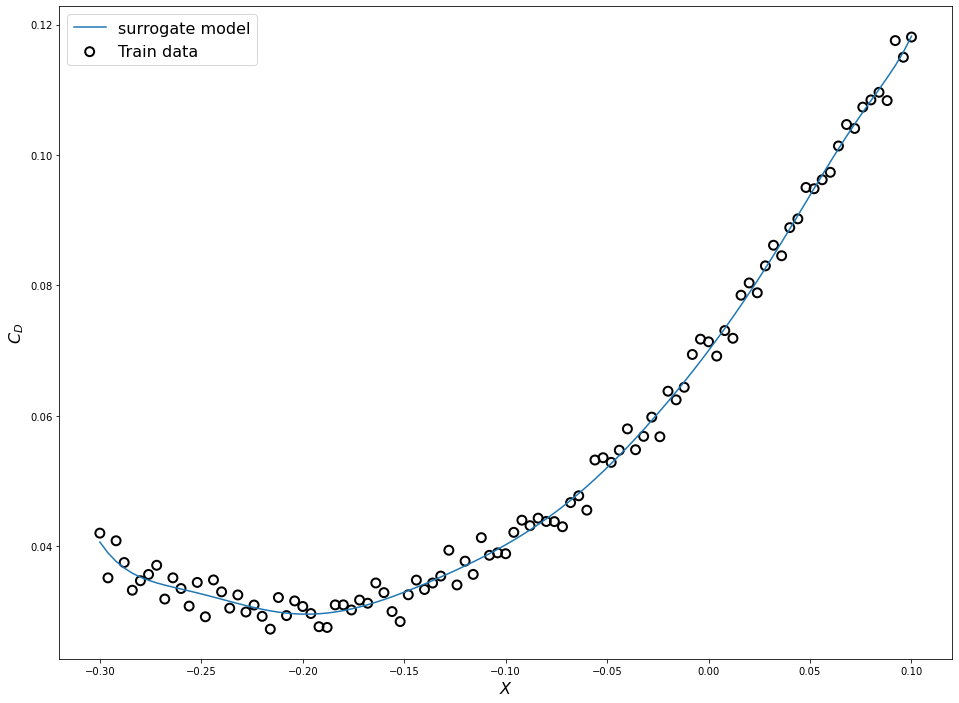

In [7]:
print(f"m = {m}, wrev = {wrev}. Ожидалось, что m = 2 и wrev = [1, 0.4, 0.07]")

size = 4
plt.figure(figsize=(4*size, 3*size))

plt.scatter(X, CD, s=80, facecolors='none', edgecolors='black', linewidths=2, label="Train data")
plt.plot(X, np.polyval(wrev,X), label="surrogate model")
plt.legend(fontsize=16)
plt.xlabel("$X$", size=16)
plt.ylabel("$C_D$", size=16)
plt.show()

<!-- ![graph](fig-2-4.png "АД-сопротивление") -->
<img src="img/fig-2-4.png" alt="АД-сопротивление" style="width^75%;"/>  
__Рис 2.4.__ Полином восьмого порядка, установленный по данным аэродинамического сопротивления. Порядок выбран с помощью кросс-валидации, коэффициенты с помощью метода максимального правдоподобия

И так, мы видим, что $m = 8$, а это значит, что полиномы восьмой степени в данном случае минимизируют метрику кросс-валидации. Если быть точным, то $m = 8$ не всегда, а _в большинстве случаев_. Это происxодит потому, что в вычислении кросс-валидационной метрики присутствует элемент случайности при разбиеннии исходных данных на подмножества, из-за чего результат может меняться от одного запуска программы к другому. Такая вариация особенно заметна, когда количество тренировочных точек относительно мало. Поэтому мы запускали вычисления несколько раз и выбрали самое часто получавшееся значение $m$.

Получив значения $m, \, wrev, \, \text{и} \, mnstd$ мы можем быстро делать предсказания. Для этого есть 2 фундаментальныx способа. Первый - это использование функции `np.polyval(p,x)`. А второй способ подразумевает предвариательную нормировку $x$ на среднее значение:  

$$\widehat{C_D}(x) = np.polyval(wrev, \bar{x})$$ 


,где  $\displaystyle \bar{x} = \frac{x-\mu(\mathbf{X})}{\sigma(\mathbf{X})}$

### Второй пример: мультимодальный тестовый случай

Давайте рассмотрим функцию одного переменного $f(x) = (6x-2)^2 sin(12x-4), \, x \in [0,1]$, изображённую на __Рис 2.5.__ пунктирной линией. Её локальные минимумы разной глубины могут вызвать трудности для некоторых процедур оптимизации, основанныx на суррогатныx моделяx. Поэтому мы будем возвращаться к этой функции и в последующих разделах. Здесь мы используем её в качестве ___мультимодального___ примера(с несколькими экстремумами) двухуровневой процедуры подгонки полиномов.  
Мы сгенерировали обучающие данные (изображены кругами на __Рис 2.5.__), добавив нормально распределённый "шум" в функцию $f$:

In [8]:
def onevar(x):
    return (6*x-2)**2 * np.sin(12*x-4)

In [9]:
X = np.arange(0,1.001,0.02)
n = len(X)
true_y = onevar(X)
y = true_y + np.random.normal(size=(n))

m, coeff, mnstd = polynomial(X, y)
surrogat_y = np.polyval(coeff,X)

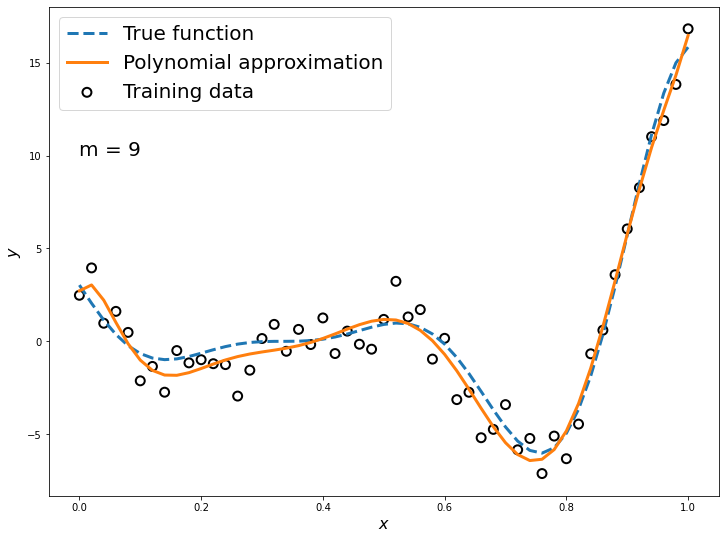

In [10]:
size = 3
plt.figure(figsize=(4*size, 3*size))

plt.plot(X, true_y, label="True function", linestyle='--', linewidth=3)
plt.scatter(X,y, s=80, facecolors='none', edgecolors='black', linewidth=2, label="Training data")
plt.plot(X, surrogat_y, label="Polynomial approximation", linewidth=3)

plt.legend(fontsize=20)
plt.xlabel('$x$', size=16)
plt.ylabel("$y$", size=16)
plt.text(0,10,f"m = {m}", size=20)
plt.show()

__Рис 2.5__ Полином $m$-го порядка, соответствующий данным, полученным в результате добавления случайного "шума" к тестовой функции, изображенной пунктирной линией.

### Что насчёт случая с $k$ - мернымни переменными?

Рассмотрев два вышеприведённыx примера, мы завершим краткий обзор полиномиальной аппроксимации, ограничившись только случаем с одной переменной. Тем не менее, конечно, можно распространить формулировку уравнения (2.10) на несколько переменных. Возможно, самый простой способ это сделать - рассмотреть эту аппрокисмацию в виде линейной комбинации базисных функций:  
$$\hat{f}(\mathbf{x}) = \sum\limits^{n_b}_{i=1}w_i \psi^{(i)},$$  
где $\psi$ взяты из множества базисныx многочленов, порядок которыx не превосxодит $m$. Например, для случая $m=3$ будет выполняться следующее: $\psi^{(i)} \in \{ 1, x_1, x_2, x_3, x_1^2, x_1x_2, x_1x_3, x_2^2, x_2x_3, x_3^2, x_1^3, ..., x_3^3\}$. 
Теперь это становится очень сложной проблемой оценки параметров, когда необходимо определить не только порядок $m$ и коэффициенты $\mathbf{w}$, но и определить, какие базисные функции мы должны выбрать из множества. Решению этой задачи было посвящено много работы, и мы завершим эту главу некоторыми указаниями (в разделе 2.6). А сейчас мы обратим наше внимание на наиболее универсальный из всех подходов к моделированию, обсуждаемых в этой книге.

## Модели [Радиальных Базисных Функций](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D0%B4%D0%B8%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE-%D0%B1%D0%B0%D0%B7%D0%B8%D1%81%D0%BD%D0%B0%D1%8F_%D1%84%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D1%8F)

Многие отрасли науки часто работают со сложными функциями, выражая их с помощью базисныx функций, которые обладают хорошо известными свойствами и легче поддаются анализу. Стоит заметить, что мы только что коснулись этого на примере многомерных многочленов.  
Один из наиболее известныx методов, который применяет эту теxнику к периодическим функциям - это ___анализ Фурье___, но здесь нас интересует более общий случай: мы xотим аппроксимировать любую гладкую непрерывную функцию как комбинацию простых базисных функций. Более конкретно, мы рассмотрим ___метод радиальных базисных функций___( _Радиальная функция_ — это любая вещественная функция, значение которой зависит только от расстояния до начала координат ${\displaystyle \phi \left(\mathbf {x} \right)=\phi \left(\left\|\mathbf {x} \right\|\right)}$ или от расстояния между некоторой другой точкой ${\displaystyle \mathbf {c} }$, называемой _центром_ : ${\displaystyle \phi \left(\mathbf {x} ,\mathbf {c} \right)=\phi \left(\left\|\mathbf {x} -\mathbf {c} \right\|\right)}$. В качестве нормы обычно выступает евклидово расстояние, хотя можно использовать и другие метрики). Мы начнём со случая _интерполяции_ радиальными базисными функциями, то есть будем строить апроксимацию в предположении, что данные не искажены шумом.

### Построение модели на незашумлённыx данныx

Давайте рассмотрим скалярную функцию $f$ (наблюдаемую без ошибок), которая на плане выборки $\mathbf{X} = \{x^{(1)}, x^{(2)}, ..., x^{(n)}\}^T$ , даёт значения $\mathbf{y} = \{y^{(1)}, y^{(2)}, ..., y^{(n)}\}^T$ . Мы ищем радиально-базисную аппроксимацию $\hat{f}$ к исходной функции в следующей форме:  
$$\hat{f}(\mathbf{x}) = \mathbf{w}^T\mathbf{\psi} = \sum\limits^{n_c}_{i=1}w_i\psi(\| \mathbf{x} - \mathbf{c}^{(i)}\|)$$  
, где $\mathbf{c}^{(i)}$ обозначает $i$-й из $n_c$ центров базисных функци, а $\mathbf{\psi}$ представляет собой вектор длины $n_c$, содержащий значения самих базисных функций $\psi$, которым в качестве аргумента поданы евклидовые расстояния между точкой прогнозирования $\mathbf{x}$ и центрами $\mathbf{c}^{(i)}$ базисных функций. Читатели, знакомые с технологией искусственных нейронных сетей, распознают эту формулировку как идентичную формулировке однослойной нейронной сети с нейронами с радиальными координатами, включающей вход $\mathbf{x}$, скрытые единицы $\mathbf{\psi}$, веса $\mathbf{w}$, линейные выходные передаточные функции и выход $\hat{f}(\mathbf{x})$.  

Приведём примеры радиальных базисных функций:
* линейная $\psi(r) = r$,
* кубическая $\psi(r) = r^3$,
* тонкая пластина с углублением $\psi(r) = r^2 \ln{r}$  

Лучшей аппроксимации в уравнении (2.15) можно добиться добавлением и варьированием дополнительных параметров в базисные функции. Процесс оценки параметров станет более сложным, но это позволит улучшить результат. Ниже представлены примеры таких параметрических функций:  
* Функция Гаусса $\psi(r) =  e^{\displaystyle-{r^2}/{2 \sigma^2}}$
* мультиквадратичная $\psi(r) = \sqrt{(r^2 + \sigma^2)}$
* обратная мультиквадратичная $\displaystyle \psi(r) = \frac{1} {\sqrt{(r^2 + \sigma^2)} }$  

Независимо от того, выбираем ли мы набор параметрических базисных функций или фиксированных, хорошей новостью является то, что $\mathbf{w}$ легко оценить. Это можно сделать с помощью условия интерполяции:  
$$\hat{f}(\mathbf{x}^{(j)}) = \sum\limits_{i=1}^{n_c} w_i \psi(\|\mathbf{x}^{(j)} - \mathbf{c}^{(i)}\|) = y^{(j)}, \, j = 1, ..., n$$  

В этом и заключается красота аппроксимаций радиальными базисными функциями. Уравнение (2.16) линейно с точки зрения весов базисной функции $\mathbf{w}$, однако предиктор $\hat{f}$ может выражать сильно нелинейные реакции! Легко видеть, что одним из условий получения уникального решения является то, что система (2.16) должна быть "квадратной", то есть $n_c = n$. Это упрощает ситуацию, если центры базисных функций фактически совпадают с обучающими точками, то есть $\mathbf{c}_i = \mathbf{x}_i, \forall i = 1,...,n$, что приводит нас к матричному уравнению:  
$$\mathbf{\Psi w = y}$$  
где $\mathbf{\Psi}$ означает так называемую _Матрицу Грама_ и определена следующим образом: $\mathbf{\Psi}_{i,j} = \psi(\|\mathbf{x}^{(j)} - \mathbf{c}^{(i)}\|), i,j=1,...,n$. Таким образом, фундаментальным этапом процесса оценки параметров является вычисление $\mathbf{w = \Psi^{-1} y}$, и именно здесь выбор базисных функций может оказать важное влияние. Например, можно показать, что при определенных предположениях гауссовские и обратные многоквадрические базисные функции всегда приводят к симметричной положительно определенной матрице Грамма (Вапник, 1998). При этом  обеспечивается безопасное вычисление $\mathbf{w}$ с помощью [разложения Холецкого](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D0%B7%D0%BB%D0%BE%D0%B6%D0%B5%D0%BD%D0%B8%D0%B5_%D0%A5%D0%BE%D0%BB%D0%B5%D1%86%D0%BA%D0%BE%D0%B3%D0%BE) ($\mathbf{\Psi = U^TU}$, причём $\mathbf{U}$ - верхняя треугольная) . Здесь также стоит упомянуть, что очень близкое расположение любых двух точек в $\mathbf{X}$ может привести к плохой обусловленности (Микелли, 1986) с последующим отказом от разложения Холецкого. Это довольно маловероятное событие, если $\mathbf{X}$ - план выборки, заполняющий пространство. Но это может стать помехой, если впоследствии в определенных областях, представляющих интерес в области проектирования, будут добавлены кластеры _точек заполнения_ (см. Раздел 3.2).  

Помимо определения $\mathbf{w}$, конечно, существует дополнительная задача - оценить любые другие параметры, введенные с помощью базисных функций. Типичным примером является базисная функция Гаусса $\mathbf{\sigma}$, обычно принимаемая за одинаковую для всех базисных функций, хотя для каждого центра можно выбрать другую, как это принято в случае базисной функции Кригинга, которая будет обсуждена позже(напомним, что мы дополнительно усложняем модель оценки параметров и надеемся получить лучшее обобщение).  

В то время как правильный выбор $\mathbf{w}$ гарантирует, что аппроксимация сможет воспроизвести обучающие данные, правильная оценка этих дополнительных параметров позволит нам минимизировать ошибку обобщения модели. Как обсуждалось ранее, этот шаг оптимизации, скажем, минимизация ошибки кросс-валидации, может быть выполнен на верхнем уровне, в то время как нахождение $\mathbf{w}$ может быть интегрировано в процесс на более низком уровне - один раз для каждого возможного значения параметра/параметров.  

Функция `rbf` является нашей реализацией этого процесса оценки параметров (на основе процедуры кросс-валидации), в то время как `predrbf` будет возвращать суррогатную модель, как только её параметры будут оценены. Процесс построения модели очень прост. Бухгалтерское устройство - это уже упоминавшаяся структура `ModelInfo`, в которой `ModelInfo.X` содержит план выборки $\mathbf{X}$, а `ModelInfo.y` - соответствующий $n$-вектор ответов $\mathbf{y}$. `ModelInfo.Code` определяет тип используемой базовой функции. После запуска `rbf` структура также будет содержать оценочные значения параметров $\mathbf{w}$, и $\mathbf{\sigma}$, если используется параметрическая базовая функция. Они сохраняются в `ModelInfo.Weights` и `ModelInfo.Sigma` соответственно. Это вся информация, необходимая `predrbf` для прогнозирования, поэтому ее единственным входом (кроме `ModelInfo`, который должен быть виден для нее через `global`) является $k$-вектор, представляющий точку, в которой мы хотим сделать прогноз.  

Следующий код иллюстрирует процесс на простом примере: мы пытаемся обучить модель следующему отклику: $f(\mathbf{x} = \frac{1}{k} \sum\limits_{i=1}^k 1-(2x_i-1)^2, \, \mathbf{x}\in[0,1]^k$. Рассмотрим случай $k=2$. Будем использовать обучающую выборку из 10-ти точек. В качестве радиальной базисной функции возмём тонкую пластину с углублением. Результаты показаны на рисунке 2.6